In [1]:
import numpy as np
import yaml
import os
from utils import find_path_to_next_simulation
from MODSIM import initialize_dynamic_scene_with_random_tracks, perform_time_steps, create_and_place_simple_legacy_camera, calculate_start_state
from errorGenerator import ErrorGenerator
from datatypes.cameraRig import CameraRig
from datatypes.virtualCamera import VirtualCamera
from datatypes.conditionState import ConditionState

from visualize import visualize_projections_json_mov, visualize_annotations_json, visualize_camera_pose_in_dsg_mov, visualize_dynamic_scene_mov, visualize_detections_json


In [2]:
# Camera types: 'STATIC_LEGACY', 'DYNAMIC'
STATIC_LEGACY = 'STATIC_LEGACY'
DYNAMIC = 'DYNAMIC'
DYNAMIC_CORAL_CAMERA = 'DYNAMIC_CORAL_CAMERA'

CAMERA_TYPE = DYNAMIC_CORAL_CAMERA

In [3]:
ERROR_CONFIG_PATH = 'detector_stats_config.yaml'
NUMBER_OF_VESSELS = 6
WRITE_TO_JSON = True
T_START = 0
T_END = 500
VISUALIZE=True
MIN_NUM_VESSELS = 1
ANNOTATION_MODE = 2


In [4]:
NO_WAVES = 0
SMALL_WAVES = 1
MEDIUM_WAVES = 2
LARGE_WAVES = 3
HUGE_WAVES = 4


WAVE_SIZE = SMALL_WAVES # int from 0-4

In [5]:
# Find folder to save simultation trial to
simulation_folder = find_path_to_next_simulation()
simulation_folder

'./simulations/5/'

# Initialize MODSIM

In [6]:
numb_states = 4

with open('detector_stats_config.yaml', 'r') as stream:
            config = yaml.safe_load(stream)
if config.get('detectionConditions'):
    start_state = calculate_start_state(config.get('detectionConditions'), numb_states)
else:
    # Default is excellent weather
    start_state = calculate_start_state({'precipitation': 0, 'fog': 0, 'wind': 0, 'darkness': 0}, numb_states)

CM = config.get('confusionMatrix')
CM0 = {'FN': round(CM['FN']/3,3), 'FP': round(CM['FP']/3,3), 'TP': 1-round(CM['FN']/3,3), 'TN': 1 - round(CM['FP']/3,3)}
CM1 = {'FN': round(CM['FN']/1.5,3), 'FP': round(CM['FP']/1.5,3), 'TP': 1-round(CM['FN']/1.5,3), 'TN': 1 - round(CM['FP']/1.5,3)}
CM2 = {'FN': round(min(CM['FN']*1.5, 0.99),3), 'FP': round(min(CM['FP']*1.5, 0.99),3), 'TP': 1-round(min(CM['FN']*1.5, 0.99),3), 'TN': 1 - round(min(CM['FP']*1.5, 0.99),3)}
CM3 = {'FN': round(min(CM['FN']*3, 0.99),3), 'FP': round(min(CM['FP']*3, 0.99),3), 'TP': 1-round(min(CM['FN']*3, 0.99),3), 'TN': 1 - round(min(CM['FP']*3, 0.99),3)}


TM =  np.array([[0.996, 0.0017, 0.0006, 0.0006],[0.0022, 0.996, 0.0017, 0.0012],[0.0012, 0.0017, 0.996, 0.0022],[0.0006, 0.0006, 0.0017, 0.996]])
states = {0: ConditionState('Excellent conditions', 0, CM0), 1: ConditionState('Good conditions', 1, CM1), 2: ConditionState('Poor conditions', 2, CM2), 3: ConditionState('Terrible conditions', 3, CM3)}


In [7]:
# Dynamic scene
dsg = initialize_dynamic_scene_with_random_tracks(NUMBER_OF_VESSELS, writeToJson=WRITE_TO_JSON, path=simulation_folder)
vessels = dsg.get_vessels()

## Error generator
errorGenerator = ErrorGenerator(ERROR_CONFIG_PATH, temporal_model=True, states=states, start_state=start_state, transition_matrix=TM)


In [8]:
if CAMERA_TYPE == STATIC_LEGACY:
    ##### Static Camera #####
    # Create simple legacy camera and place it in the dynamic scene
    camera = create_and_place_simple_legacy_camera(dsg.get_larges_radius(), dsg.get_path_centre())
    camera_rig = CameraRig(camera, wave_size=WAVE_SIZE)

In [9]:
if CAMERA_TYPE == DYNAMIC:
    ###### Dynamic Camera ######
    focal_length = 50*10**-3
    image_bounds = (3600, 2400) # Pixels (x,y)
    film_size = (36*10**-3, 24*10**-3)
    px = film_size[0]/image_bounds[0]
    py = film_size[1]/image_bounds[1]
    principal_point = (image_bounds[0]/2,image_bounds[1]/2)
    width_of_sensor = 36*10**-3 # Width of sensor
    roll_vcf = 0
    yaw_vcf = 0
    pitch_vcf = np.pi/200
    vessel = vessels[3]
    pos_vcf = np.array([vessel.get_length()/2, 0, vessel.get_air_draft()/2])

    camera = VirtualCamera(focal_length, px, py, principal_point, image_bounds)
    camera.place_camera_on_vessel(pos_vcf, roll_vcf, pitch_vcf, yaw_vcf)
    camera_rig = CameraRig(camera, vessel, wave_size=WAVE_SIZE)

In [10]:
if CAMERA_TYPE == DYNAMIC_CORAL_CAMERA:
    # https://www.tme.eu/Document/3e25990c825098a96a442d65b17c6632/CORAL-CAMERA-5MP.pdf
    ###### Dynamic Camera ######
    # Intrinsics
    # NB! Make sure everything is in meters
    focal_length = 2.5*10**-3
    image_bounds = (2592, 1933) # Pixels (x,y)
    #film_size = (1.4*10**-3, 1.4*10**-3)
    px = 1.4*10**-6
    py = 1.4*10**-6
    #px = 2*10**-6
    #py = 2*10**-6
    principal_point = (image_bounds[0]/2,image_bounds[1]/2)
    width_of_sensor = 36*10**-3 # Width of sensor

    # Position
    roll_vcf = 0
    yaw_vcf = 0
    pitch_vcf = np.pi/200
    vessel = vessels[3]
    pos_vcf = np.array([vessel.get_length()/2, 0, vessel.get_air_draft()/2])

    camera = VirtualCamera(focal_length, px, py, principal_point, image_bounds)
    camera.place_camera_on_vessel(pos_vcf, roll_vcf, pitch_vcf, yaw_vcf)
    camera_rig = CameraRig(camera, vessel, wave_size=WAVE_SIZE)


# Perform time steps

In [11]:
#pps, bbs, eBBs = perform_one_time_step_class(dsg, errorGenerator, camera_rig, 0, writeToJson=WRITE_TO_JSON, path=simulation_folder)

In [12]:
pps, bbs, eBBs = perform_time_steps(T_START, T_END, dsg, errorGenerator, camera_rig, annotation_mode=ANNOTATION_MODE, writeToJson=WRITE_TO_JSON, path=simulation_folder)

i: 0 Found points [1292.31494644  938.42501309], [1299.66172223  938.42539481]
i: 0 Found points [1292.31479872  938.38933156], [1299.66131327  938.38963979]
i: 0 Found points [1292.31438894  938.28224942], [1299.66060816  938.28241071]
i: 0 Found points [1292.31193979  938.21086115], [1299.65797121  938.21036128]
i: 0 Found points [1292.30937375  938.06831727], [1299.65540516  938.06715626]
i: 0 Found points [1292.3067861   937.94363286], [1299.65281749  937.94181071]
i: 0 Found points [1292.26775609  937.81921964], [1299.68243647  937.81619574]
i: 0 Found points [1292.26395311  937.67682771], [1299.67863346  937.67283989]
i: 0 Found points [1292.25812053  937.48111773], [1299.67265355  937.47564708]
i: 0 Found points [1292.25613819  937.26702764], [1299.67081849  937.261112  ]
i: 0 Found points [1292.25534212  937.1417922 ], [1299.67024388  937.1357281 ]
i: 0 Found points [1292.25269403  937.05282876], [1299.66744847  937.04609744]
i: 0 Found points [1292.21616716  937.01744022], [12

# Visualize

Loading projections from json
Visualizing projections
Moviepy - Building video ./simulations/5/projected_points.mp4.
Moviepy - Writing video ./simulations/5/projected_points.mp4



Moviepy - Done !
Moviepy - video ready ./simulations/5/projected_points.mp4


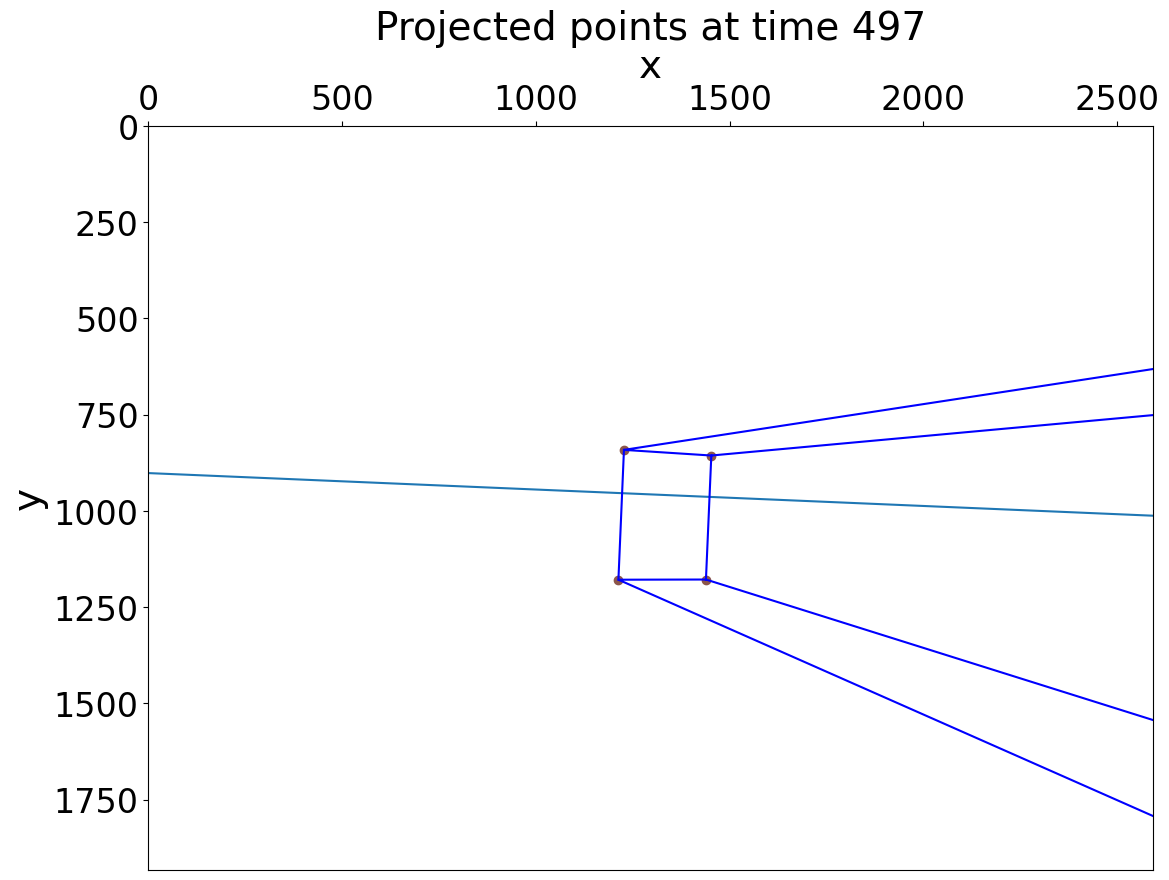

In [13]:
# Visualize from json files
if VISUALIZE:
    if CAMERA_TYPE == DYNAMIC:
        x_y_lim = dsg.get_larges_radius() + 250
    else:
        x_y_lim = None
    pps_path = os.path.join(simulation_folder, 'projectedPoints.json')
    annots_path = os.path.join(simulation_folder, 'annotations.json')
    detections_path = os.path.join(simulation_folder, 'detections.json')
    #visualize_dynamic_scene_mov(vessels, folder_path=simulation_folder)
    #visualize_camera_pose_in_dsg_mov(camera_rig, vessels, folder_path=simulation_folder, y_x_lim=x_y_lim)
    visualize_projections_json_mov(pps_path, camera_rig.camera.image_bounds, camera_rig.horizon, folder_path=simulation_folder, display_when_min_vessels=MIN_NUM_VESSELS)
    #visualize_annotations_json(annots_path, camera_rig.camera.image_bounds, horizon=camera_rig.horizon, folder_path=simulation_folder, display_when_min_vessels=MIN_NUM_VESSELS)
    #visualize_detections_json(detections_path, camera_rig.camera.image_bounds, horizon=camera_rig.horizon, show_annotations=True, annotations_path=annots_path, folder_path=simulation_folder, display_when_min_vessels=MIN_NUM_VESSELS, temporal_state_history=errorGenerator.temporal_model.previous_states, temporal_state_names=errorGenerator.temporal_model.state_names)
